In [1]:
#mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install --upgrade tables

     |████████████████████████████████| 4.3MB 4.7MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [3]:
!pip install tf_keras_vis

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu May  7 15:23:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib
#working_dir = pathlib.Path().absolute()
#os.chdir(working_dir)
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization,concatenate
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image
import tables
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics as metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

In [0]:
import skimage
from skimage.transform import rotate
import random
from sklearn.preprocessing import OneHotEncoder

In [0]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

cell_type_idx_dict={0:'Actinic keratoses',1:'Basal cell carcinoma',
                    2:'Benign keratosis-like lesions',
                    3:'Dermatofibroma',4:'Melanocytic nevi',
                    5:'Melanoma',6:'Vascular lesions'    
}

In [0]:
meta_df_64_48=pd.read_hdf('/content/drive/My Drive/HAM10000/ham10000_64_48.h5')
meta_df_48_36=pd.read_hdf('/content/drive/My Drive/HAM10000/ham10000_48_36.h5')
meta_df_32_24=pd.read_hdf('/content/drive/My Drive/HAM10000/ham10000_32_24.h5')

In [0]:
np.random.seed(1234)
nevi_selected=np.random.choice(meta_df_32_24[meta_df_32_24.cell_type_idx==4].index,1117,replace=False)

In [0]:
meta_df_32_24_filtered=meta_df_32_24[meta_df_32_24.cell_type_idx != 4].append(meta_df_32_24.loc[nevi_selected])
meta_df_64_48_filtered=meta_df_64_48[meta_df_64_48.cell_type_idx != 4].append(meta_df_64_48.loc[nevi_selected])
meta_df_48_36_filtered=meta_df_48_36[meta_df_48_36.cell_type_idx != 4].append(meta_df_48_36.loc[nevi_selected])

In [0]:
def image_augmentation(row):
  row_new=row.copy()
  if np.random.random()<0.5:
    angle=np.random.uniform(-30,30)
  else:
    angle=np.random.uniform(150,210)
  row_new.image_rgb=skimage.transform.rotate(row.image_rgb,angle)
  row_new.image_gray=skimage.transform.rotate(row.image_gray,angle)
  return row_new

In [0]:
def df_augmentation(df):
  df_aug=df[1:1]
  for index, row in df.iterrows():
    if row.cell_type_idx in [4,5,2]:      
      row_new=image_augmentation(row)
      df_aug=df_aug.append(row_new)
    if row.cell_type_idx==1:
      for i in range(2):
        row_new=image_augmentation(row)
        df_aug=df_aug.append(row_new)
    if row.cell_type_idx==0:
      for i in range(3):
        row_new=image_augmentation(row)
        df_aug=df_aug.append(row_new)
    if row.cell_type_idx==6:
      for i in range(7):
        row_new=image_augmentation(row)
        df_aug=df_aug.append(row_new)
    if row.cell_type_idx==3:
      for i in range(8):
        row_new=image_augmentation(row)
        df_aug=df_aug.append(row_new)
  return df_aug



In [0]:
np.random.seed(3333)
meta_df_32_24_aug=df_augmentation(meta_df_32_24_filtered)


In [0]:
np.random.seed(3333)
meta_df_48_36_aug=df_augmentation(meta_df_48_36_filtered)


In [0]:
np.random.seed(3333)
meta_df_64_48_aug=df_augmentation(meta_df_64_48_filtered)


In [0]:
OHE_sex=OneHotEncoder(sparse=False)
OHE_localization=OneHotEncoder(sparse=False)
OHE_sex.fit(np.array(meta_df_32_24_aug.sex).reshape((-1,1)))
OHE_localization.fit(np.array(meta_df_32_24_aug.localization).reshape((-1,1)))
meta_df_32_24_aug['sex_onehot']=meta_df_32_24_aug['sex'].map(lambda x:OHE_sex.transform(np.array(x).reshape((-1,1)))[0])
meta_df_32_24_aug['localization_onehot']=meta_df_32_24_aug['localization'].map(lambda x:OHE_localization.transform(np.array(x).reshape((-1,1)))[0])


In [80]:
meta_df_32_24_aug.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image_rgb,image_gray,sex_onehot,localization_onehot
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.3843137254901961, 0.6917469...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.10195728748947068, 0.058864824239010904, ...","[[0.07845425752233195, 0.20002410753054312, 0....","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.3333333...","[[0.0, 0.0, 0.4196078431372549, 0.651000000983...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.19599663208315668, 0.399605...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.4596551826932911, 0.3893...","[[0.0, 0.41276793826437963, 0.7476883340377246...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [79]:
OHE_sex=OneHotEncoder(sparse=False)
OHE_localization=OneHotEncoder(sparse=False)
OHE_sex.fit(np.array(meta_df_48_36_aug.sex).reshape((-1,1)))
OHE_localization.fit(np.array(meta_df_48_36_aug.localization).reshape((-1,1)))
meta_df_48_36_aug['sex_onehot']=meta_df_48_36_aug['sex'].map(lambda x:OHE_sex.transform(np.array(x).reshape((-1,1)))[0])
meta_df_48_36_aug['localization_onehot']=meta_df_48_36_aug['localization'].map(lambda x:OHE_localization.transform(np.array(x).reshape((-1,1)))[0])
meta_df_48_36_aug.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image_rgb,image_gray,sex_onehot,localization_onehot
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.41233515694745004...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0899820326965759, 0.050871415557346665, 0...","[[0.06666666666666667, 0.1021161789850991, 0.2...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.40784313725490196, 0.607640...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.22022961822334863...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.6134750...","[[0.0, 0.0, 0.549143815285688, 0.7128569109748...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [81]:
OHE_sex=OneHotEncoder(sparse=False)
OHE_localization=OneHotEncoder(sparse=False)
OHE_sex.fit(np.array(meta_df_64_48_aug.sex).reshape((-1,1)))
OHE_localization.fit(np.array(meta_df_64_48_aug.localization).reshape((-1,1)))
meta_df_64_48_aug['sex_onehot']=meta_df_64_48_aug['sex'].map(lambda x:OHE_sex.transform(np.array(x).reshape((-1,1)))[0])
meta_df_64_48_aug['localization_onehot']=meta_df_64_48_aug['localization'].map(lambda x:OHE_localization.transform(np.array(x).reshape((-1,1)))[0])
meta_df_64_48_aug.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image_rgb,image_gray,sex_onehot,localization_onehot
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4953433...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0898431463449199, 0.05076861560265712, 0....","[[0.06666666666666667, 0.07462472429526427, 0....","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.37254901960784315...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2503493...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,skin-cancer-mnist-ham10000/HAM10000_images/ISI...,Benign keratosis-like lesions,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.1764705...","[[0.0, 0.0, 0.21568627450980393, 0.61882665323...","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [0]:
rgb_df_64_48=meta_df_64_48_aug.drop(columns=['image_gray'])
gray_df_64_48=meta_df_64_48_aug.drop(columns=['image_rgb'])

rgb_df_48_36=meta_df_48_36_aug.drop(columns=['image_gray'])
gray_df_48_36=meta_df_48_36_aug.drop(columns=['image_rgb'])

rgb_df_32_24=meta_df_32_24_aug.drop(columns=['image_gray'])
gray_df_32_24=meta_df_32_24_aug.drop(columns=['image_rgb'])

Augmented dataset

In [0]:
rgb_train_df_64_48,rgb_test_df_64_48=train_test_split(rgb_df_64_48,test_size=0.2,random_state=6862,stratify=rgb_df_64_48.cell_type_idx)
rgb_train_df_64_48,rgb_validation_df_64_48=train_test_split(rgb_train_df_64_48,test_size=0.25,random_state=6036,stratify=rgb_train_df_64_48.cell_type_idx)

gray_train_df_64_48,gray_test_df_64_48=train_test_split(gray_df_64_48,test_size=0.2,random_state=6862,stratify=gray_df_64_48.cell_type_idx)
gray_train_df_64_48,gray_validation_df_64_48=train_test_split(gray_train_df_64_48,test_size=0.25,random_state=6036,stratify=gray_train_df_64_48.cell_type_idx)

rgb_train_df_48_36,rgb_test_df_48_36=train_test_split(rgb_df_48_36,test_size=0.2,random_state=6862,stratify=rgb_df_48_36.cell_type_idx)
rgb_train_df_48_36,rgb_validation_df_48_36=train_test_split(rgb_train_df_48_36,test_size=0.25,random_state=6036,stratify=rgb_train_df_48_36.cell_type_idx)

gray_train_df_48_36,gray_test_df_48_36=train_test_split(gray_df_48_36,test_size=0.2,random_state=6862,stratify=gray_df_48_36.cell_type_idx)
gray_train_df_48_36,gray_validation_df_48_36=train_test_split(gray_train_df_48_36,test_size=0.25,random_state=6036,stratify=gray_train_df_48_36.cell_type_idx)

rgb_train_df_32_24,rgb_test_df_32_24=train_test_split(rgb_df_32_24,test_size=0.2,random_state=6862,stratify=rgb_df_32_24.cell_type_idx)
rgb_train_df_32_24,rgb_validation_df_32_24=train_test_split(rgb_train_df_32_24,test_size=0.25,random_state=6036,stratify=rgb_train_df_32_24.cell_type_idx)

gray_train_df_32_24,gray_test_df_32_24=train_test_split(gray_df_32_24,test_size=0.2,random_state=6862,stratify=gray_df_32_24.cell_type_idx)
gray_train_df_32_24,gray_validation_df_32_24=train_test_split(gray_train_df_32_24,test_size=0.25,random_state=6036,stratify=gray_train_df_32_24.cell_type_idx)

In [97]:
np.asarray(rgb_train_df_64_48.sex_onehot.tolist())

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [0]:
rgb_x_train_64_48=np.asarray(rgb_train_df_64_48.image_rgb.tolist())
rgb_age_train_64_48=np.asarray(rgb_train_df_64_48.age.tolist()).reshape(-1,1)
rgb_sex_train_64_48=np.asarray(rgb_train_df_64_48.sex_onehot.tolist())
rgb_localization_train_64_48=np.asarray(rgb_train_df_64_48.localization_onehot.tolist())
rgb_y_train_64_48=np.asarray(rgb_train_df_64_48.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_validation_64_48=np.asarray(rgb_validation_df_64_48.image_rgb.tolist())
rgb_age_validation_64_48=np.asarray(rgb_validation_df_64_48.age.tolist()).reshape(-1,1)
rgb_sex_validation_64_48=np.asarray(rgb_validation_df_64_48.sex_onehot.tolist())
rgb_localization_validation_64_48=np.asarray(rgb_validation_df_64_48.localization_onehot.tolist())
rgb_y_validation_64_48=np.asarray(rgb_validation_df_64_48.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_test_64_48=np.asarray(rgb_test_df_64_48.image_rgb.tolist())
rgb_age_test_64_48=np.asarray(rgb_test_df_64_48.age.tolist()).reshape(-1,1)
rgb_sex_test_64_48=np.asarray(rgb_test_df_64_48.sex_onehot.tolist())
rgb_localization_test_64_48=np.asarray(rgb_test_df_64_48.localization_onehot.tolist())
rgb_y_test_64_48=np.asarray(rgb_test_df_64_48.cell_type_idx.tolist()).reshape(-1,1)

rgb_x_train_48_36=np.asarray(rgb_train_df_48_36.image_rgb.tolist())
rgb_age_train_48_36=np.asarray(rgb_train_df_48_36.age.tolist()).reshape(-1,1)
rgb_sex_train_48_36=np.asarray(rgb_train_df_48_36.sex_onehot.tolist())
rgb_localization_train_48_36=np.asarray(rgb_train_df_48_36.localization_onehot.tolist())
rgb_y_train_48_36=np.asarray(rgb_train_df_48_36.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_validation_48_36=np.asarray(rgb_validation_df_48_36.image_rgb.tolist())
rgb_age_validation_48_36=np.asarray(rgb_validation_df_48_36.age.tolist()).reshape(-1,1)
rgb_sex_validation_48_36=np.asarray(rgb_validation_df_48_36.sex_onehot.tolist())
rgb_localization_validation_48_36=np.asarray(rgb_validation_df_48_36.localization_onehot.tolist())
rgb_y_validation_48_36=np.asarray(rgb_validation_df_48_36.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_test_48_36=np.asarray(rgb_test_df_48_36.image_rgb.tolist())
rgb_age_test_48_36=np.asarray(rgb_test_df_48_36.age.tolist()).reshape(-1,1)
rgb_sex_test_48_36=np.asarray(rgb_test_df_48_36.sex_onehot.tolist())
rgb_localization_test_48_36=np.asarray(rgb_test_df_48_36.localization_onehot.tolist())
rgb_y_test_48_36=np.asarray(rgb_test_df_48_36.cell_type_idx.tolist()).reshape(-1,1)

rgb_x_train_32_24=np.asarray(rgb_train_df_32_24.image_rgb.tolist())
rgb_age_train_32_24=np.asarray(rgb_train_df_32_24.age.tolist()).reshape(-1,1)
rgb_sex_train_32_24=np.asarray(rgb_train_df_32_24.sex_onehot.tolist())
rgb_localization_train_32_24=np.asarray(rgb_train_df_32_24.localization_onehot.tolist())
rgb_y_train_32_24=np.asarray(rgb_train_df_32_24.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_validation_32_24=np.asarray(rgb_validation_df_32_24.image_rgb.tolist())
rgb_age_validation_32_24=np.asarray(rgb_validation_df_32_24.age.tolist()).reshape(-1,1)
rgb_sex_validation_32_24=np.asarray(rgb_validation_df_32_24.sex_onehot.tolist())
rgb_localization_validation_32_24=np.asarray(rgb_validation_df_32_24.localization_onehot.tolist())
rgb_y_validation_32_24=np.asarray(rgb_validation_df_32_24.cell_type_idx.tolist()).reshape(-1,1)
rgb_x_test_32_24=np.asarray(rgb_test_df_32_24.image_rgb.tolist())
rgb_age_test_32_24=np.asarray(rgb_test_df_32_24.age.tolist()).reshape(-1,1)
rgb_sex_test_32_24=np.asarray(rgb_test_df_32_24.sex_onehot.tolist())
rgb_localization_test_32_24=np.asarray(rgb_test_df_32_24.localization_onehot.tolist())
rgb_y_test_32_24=np.asarray(rgb_test_df_32_24.cell_type_idx.tolist()).reshape(-1,1)

In [0]:
gray_x_train_64_48=np.asarray(gray_train_df_64_48.image_gray.tolist())
gray_x_train_64_48=np.expand_dims(gray_x_train_64_48,axis=3)
gray_age_train_64_48=np.asarray(gray_train_df_64_48.age.tolist()).reshape(-1,1)
gray_sex_train_64_48=np.asarray(gray_train_df_64_48.sex_onehot.tolist())
gray_localization_train_64_48=np.asarray(gray_train_df_64_48.localization_onehot.tolist())
gray_y_train_64_48=np.asarray(gray_train_df_64_48.cell_type_idx.tolist()).reshape(-1,1)
gray_x_validation_64_48=np.asarray(gray_validation_df_64_48.image_gray.tolist())
gray_age_validation_64_48=np.asarray(gray_validation_df_64_48.age.tolist()).reshape(-1,1)
gray_sex_validation_64_48=np.asarray(gray_validation_df_64_48.sex_onehot.tolist())
gray_localization_validation_64_48=np.asarray(gray_validation_df_64_48.localization_onehot.tolist())
gray_y_validation_64_48=np.asarray(gray_validation_df_64_48.cell_type_idx.tolist()).reshape(-1,1)
gray_x_test_64_48=np.asarray(gray_test_df_64_48.image_gray.tolist())
gray_age_test_64_48=np.asarray(gray_test_df_64_48.age.tolist()).reshape(-1,1)
gray_sex_test_64_48=np.asarray(gray_test_df_64_48.sex_onehot.tolist())
gray_localization_test_64_48=np.asarray(gray_test_df_64_48.localization_onehot.tolist())
gray_y_test_64_48=np.asarray(gray_test_df_64_48.cell_type_idx.tolist()).reshape(-1,1)

gray_x_train_48_36=np.asarray(gray_train_df_48_36.image_gray.tolist())
gray_x_train_48_36=np.expand_dims(gray_x_train_48_36,axis=3)
gray_age_train_48_36=np.asarray(gray_train_df_48_36.age.tolist()).reshape(-1,1)
gray_sex_train_48_36=np.asarray(gray_train_df_48_36.sex_onehot.tolist())
gray_localization_train_48_36=np.asarray(gray_train_df_48_36.localization_onehot.tolist())
gray_y_train_48_36=np.asarray(gray_train_df_48_36.cell_type_idx.tolist()).reshape(-1,1)
gray_x_validation_48_36=np.asarray(gray_validation_df_48_36.image_gray.tolist())
gray_age_validation_48_36=np.asarray(gray_validation_df_48_36.age.tolist()).reshape(-1,1)
gray_sex_validation_48_36=np.asarray(gray_validation_df_48_36.sex_onehot.tolist())
gray_localization_validation_48_36=np.asarray(gray_validation_df_48_36.localization_onehot.tolist())
gray_y_validation_48_36=np.asarray(gray_validation_df_48_36.cell_type_idx.tolist()).reshape(-1,1)
gray_x_test_48_36=np.asarray(gray_test_df_48_36.image_gray.tolist())
gray_age_test_48_36=np.asarray(gray_test_df_48_36.age.tolist()).reshape(-1,1)
gray_sex_test_48_36=np.asarray(gray_test_df_48_36.sex_onehot.tolist())
gray_localization_test_48_36=np.asarray(gray_test_df_48_36.localization_onehot.tolist())
gray_y_test_48_36=np.asarray(gray_test_df_48_36.cell_type_idx.tolist()).reshape(-1,1)

gray_x_train_32_24=np.asarray(gray_train_df_32_24.image_gray.tolist())
gray_x_train_32_24=np.expand_dims(gray_x_train_32_24,axis=3)
gray_age_train_32_24=np.asarray(gray_train_df_32_24.age.tolist()).reshape(-1,1)
gray_sex_train_32_24=np.asarray(gray_train_df_32_24.sex_onehot.tolist())
gray_localization_train_32_24=np.asarray(gray_train_df_32_24.localization_onehot.tolist())
gray_y_train_32_24=np.asarray(gray_train_df_32_24.cell_type_idx.tolist()).reshape(-1,1)
gray_x_validation_32_24=np.asarray(gray_validation_df_32_24.image_gray.tolist())
gray_age_validation_32_24=np.asarray(gray_validation_df_32_24.age.tolist()).reshape(-1,1)
gray_sex_validation_32_24=np.asarray(gray_validation_df_32_24.sex_onehot.tolist())
gray_localization_validation_32_24=np.asarray(gray_validation_df_32_24.localization_onehot.tolist())
gray_y_validation_32_24=np.asarray(gray_validation_df_32_24.cell_type_idx.tolist()).reshape(-1,1)
gray_x_test_32_24=np.asarray(gray_test_df_32_24.image_gray.tolist())
gray_age_test_32_24=np.asarray(gray_test_df_32_24.age.tolist()).reshape(-1,1)
gray_sex_test_32_24=np.asarray(gray_test_df_32_24.sex_onehot.tolist())
gray_localization_test_32_24=np.asarray(gray_test_df_32_24.localization_onehot.tolist())
gray_y_test_32_24=np.asarray(gray_test_df_32_24.cell_type_idx.tolist()).reshape(-1,1)

In [0]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',
                          cmap=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    

In [0]:
def plot_roc(model,x,y,title='ROC'):
  import sklearn.metrics as metrics
  fpr0, tpr0, threshold=metrics.roc_curve(y==0,model.predict(x)[:,0])
  roc_auc0=metrics.auc(fpr0,tpr0)

  fpr1, tpr1, threshold=metrics.roc_curve(y==1,model.predict(x)[:,1])
  roc_auc1=metrics.auc(fpr1,tpr1)

  fpr2, tpr2, threshold=metrics.roc_curve(y==2,model.predict(x)[:,2])
  roc_auc2=metrics.auc(fpr2,tpr2)

  fpr3, tpr3, threshold=metrics.roc_curve(y==3,model.predict(x)[:,3])
  roc_auc3=metrics.auc(fpr3,tpr3)

  fpr4, tpr4, threshold=metrics.roc_curve(y==4,model.predict(x)[:,4])
  roc_auc4=metrics.auc(fpr4,tpr4)

  fpr5, tpr5, threshold=metrics.roc_curve(y==5,model.predict(x)[:,5])
  roc_auc5=metrics.auc(fpr5,tpr5)

  fpr6, tpr6, threshold=metrics.roc_curve(y==6,model.predict(x)[:,6])
  roc_auc6=metrics.auc(fpr6,tpr6)

  plt.plot(fpr0, tpr0, label = f'{cell_type_idx_dict[0]}, auc = {round(roc_auc0,3)}')
  plt.plot(fpr1, tpr1, label = f'{cell_type_idx_dict[1]}, auc = {round(roc_auc1,3)}')
  plt.plot(fpr2, tpr2, label = f'{cell_type_idx_dict[2]}, auc = {round(roc_auc2,3)}')
  plt.plot(fpr3, tpr3, label = f'{cell_type_idx_dict[3]}, auc = {round(roc_auc3,3)}')
  plt.plot(fpr4, tpr4, label = f'{cell_type_idx_dict[4]}, auc = {round(roc_auc4,3)}')
  plt.plot(fpr5, tpr5, label = f'{cell_type_idx_dict[5]}, auc = {round(roc_auc5,3)}')
  plt.plot(fpr6, tpr6, label = f'{cell_type_idx_dict[6]}, auc = {round(roc_auc6,3)}')
  plt.title(title)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend()

In [0]:
def plot_history(h,title='History'):
  fig, ax = plt.subplots(1,2,figsize = (15,5))
  
  ax[0].plot(h.history['accuracy'], label = "Training data")
  ax[0].plot(h.history['val_accuracy'], label = "Validation data")
  ax[0].set_xlabel("epoch")
  ax[0].set_ylabel("accuracy")
  ax[0].set_title(title+" Accuracy")
  ax[0].legend()

  ax[1].plot(h.history['loss'], label = "Training data")
  ax[1].plot(h.history['val_loss'], label = "Validation data")
  ax[1].set_xlabel("epoch")
  ax[1].set_ylabel("loss")
  ax[1].set_title(title+" Loss")
  ax[1].legend()

  plt.show()

In [0]:
rgb_64_48_input=Input(shape=(48,64,3),name='Image')
rgb_64_48_age=Input(shape=1,name='Age')
rgb_64_48_sex=Input(shape=3,name='Sex')
rgb_64_48_localization=Input(shape=14,name='Localization')
rgb_64_48_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(rgb_64_48_input)
rgb_64_48_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(rgb_64_48_CNN)
rgb_64_48_CNN=BatchNormalization()(rgb_64_48_CNN)
rgb_64_48_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_64_48_CNN)
rgb_64_48_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_64_48_CNN)
rgb_64_48_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_64_48_CNN)
rgb_64_48_CNN=BatchNormalization()(rgb_64_48_CNN)
rgb_64_48_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_64_48_CNN)
rgb_64_48_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_64_48_CNN)
rgb_64_48_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_64_48_CNN)
rgb_64_48_CNN=BatchNormalization()(rgb_64_48_CNN)
rgb_64_48_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_64_48_CNN)
rgb_64_48_flatten=Flatten()(rgb_64_48_CNN)
rgb_64_48_conc=concatenate([rgb_64_48_flatten,rgb_64_48_age,rgb_64_48_sex,rgb_64_48_localization])
rgb_64_48_dense=Dense(128,activation='relu')(rgb_64_48_conc)
rgb_64_48_dense=Dense(64,activation='relu')(rgb_64_48_dense)
rgb_64_48_output=Dense(7,activation='softmax')(rgb_64_48_dense)
rgb_64_48_concatenated=Model(inputs=[rgb_64_48_input,rgb_64_48_age,rgb_64_48_sex,rgb_64_48_localization],outputs=rgb_64_48_output)

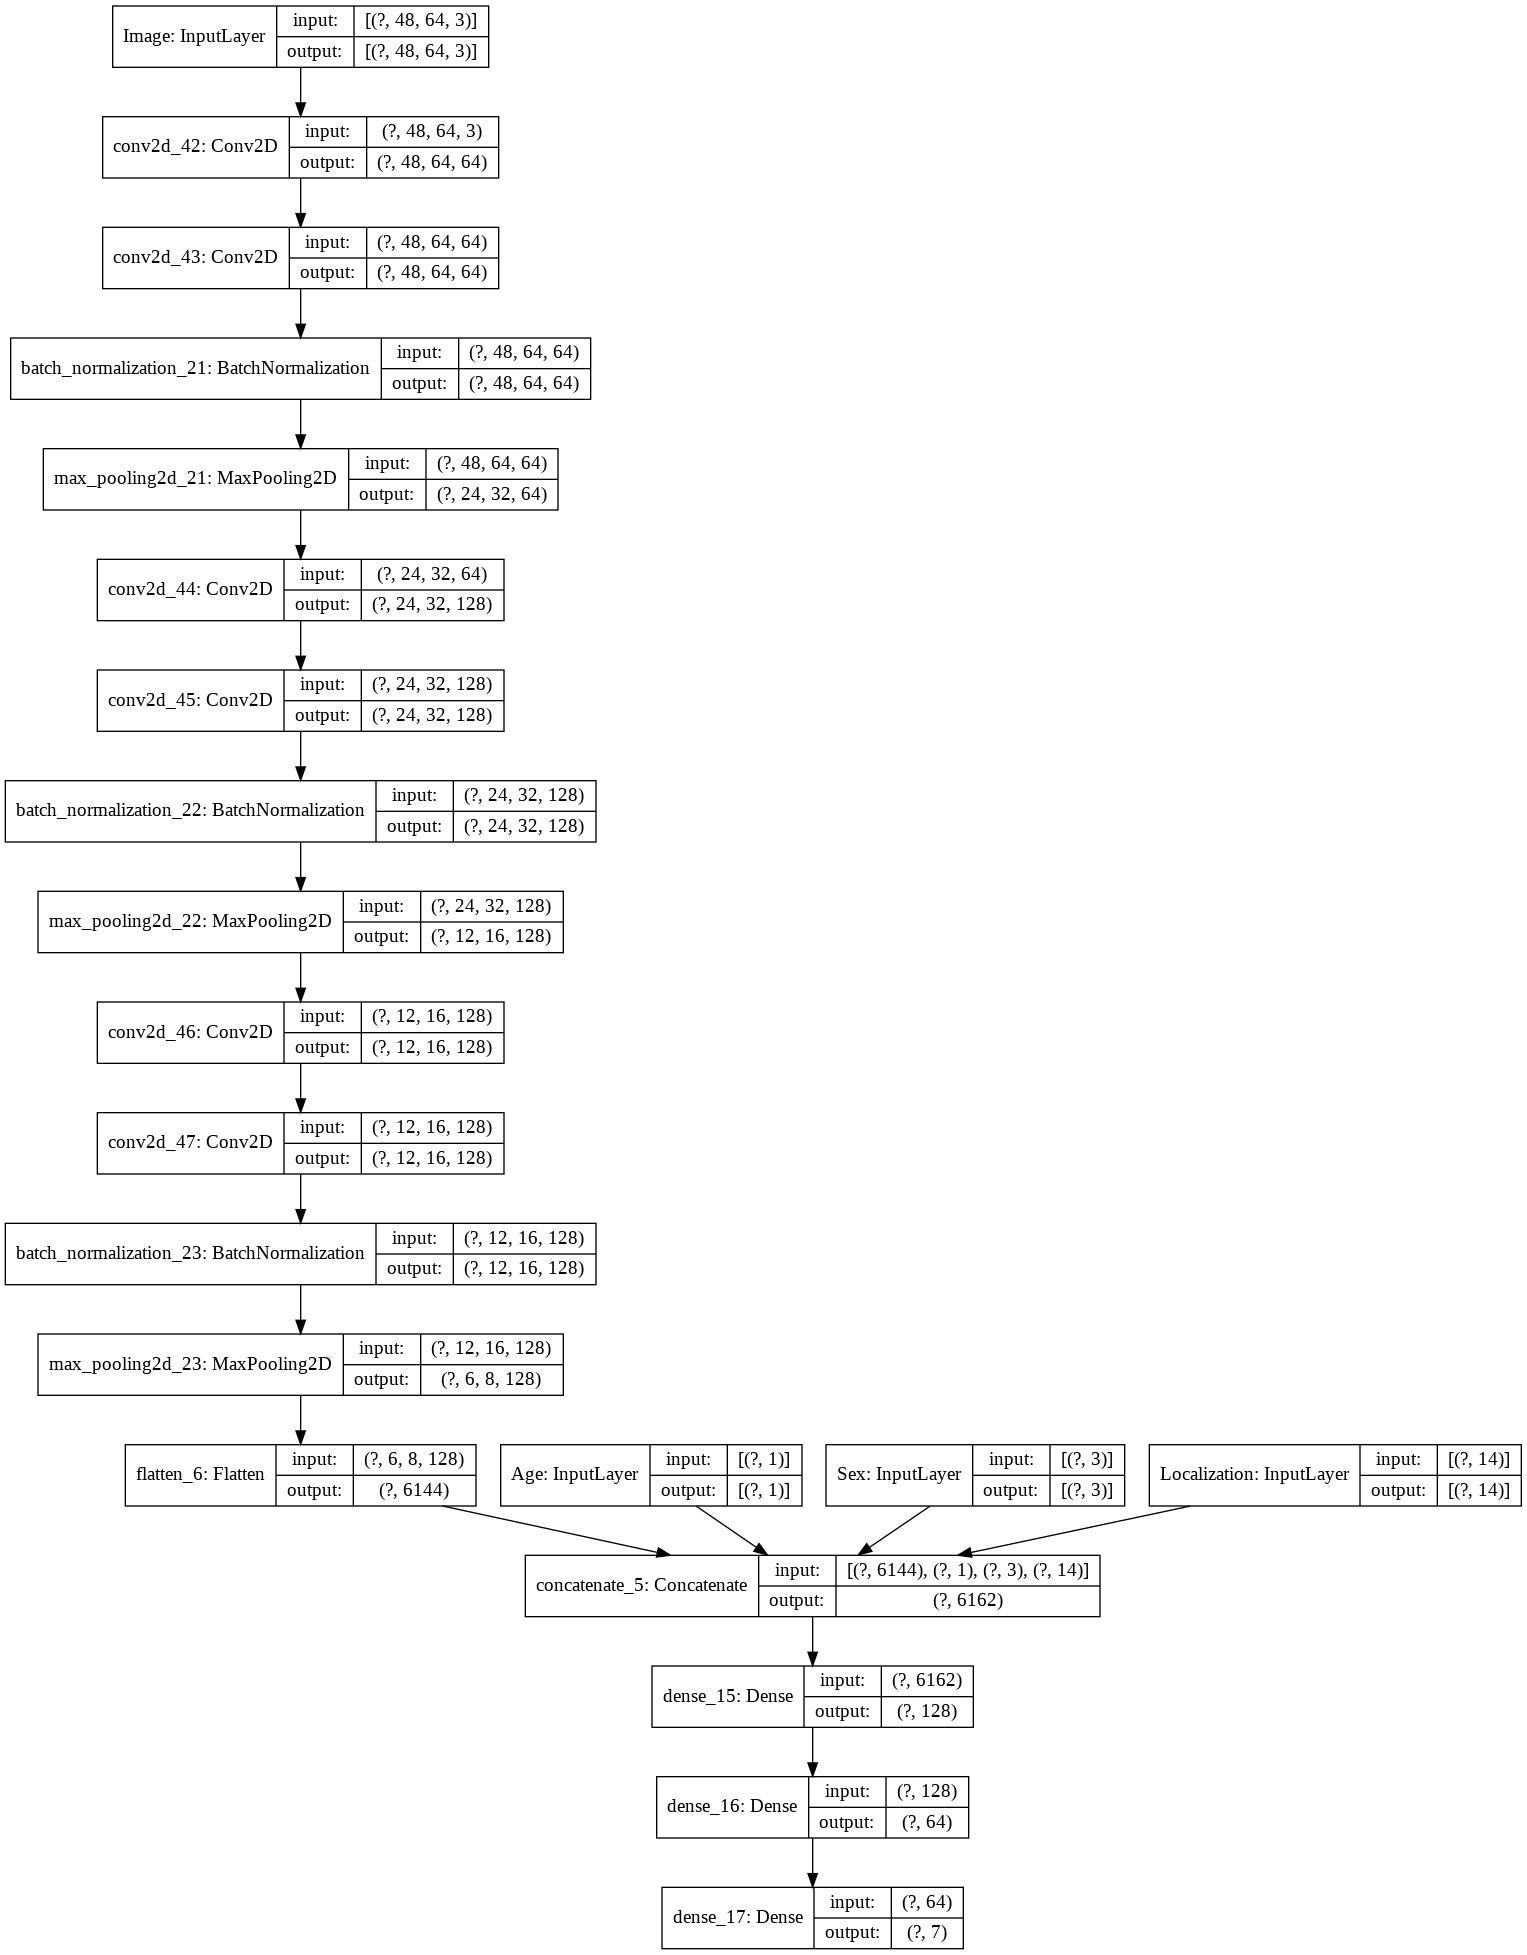

In [111]:
tf.keras.utils.plot_model(rgb_64_48_concatenated,show_shapes=True)

In [0]:
gray_64_48_input=Input(shape=(48,64,1),name='Image')
gray_64_48_age=Input(shape=1,name='Age')
gray_64_48_sex=Input(shape=3,name='Sex')
gray_64_48_localization=Input(shape=14,name='Localization')
gray_64_48_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(gray_64_48_input)
gray_64_48_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(gray_64_48_CNN)
gray_64_48_CNN=BatchNormalization()(gray_64_48_CNN)
gray_64_48_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_64_48_CNN)
gray_64_48_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_64_48_CNN)
gray_64_48_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_64_48_CNN)
gray_64_48_CNN=BatchNormalization()(gray_64_48_CNN)
gray_64_48_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_64_48_CNN)
gray_64_48_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_64_48_CNN)
gray_64_48_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_64_48_CNN)
gray_64_48_CNN=BatchNormalization()(gray_64_48_CNN)
gray_64_48_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_64_48_CNN)
gray_64_48_flatten=Flatten()(gray_64_48_CNN)
gray_64_48_conc=concatenate([gray_64_48_flatten,gray_64_48_age,gray_64_48_sex,gray_64_48_localization])
gray_64_48_dense=Dense(128,activation='relu')(gray_64_48_conc)
gray_64_48_dense=Dense(64,activation='relu')(gray_64_48_dense)
gray_64_48_output=Dense(7,activation='softmax')(gray_64_48_dense)
gray_64_48_concatenated=Model(inputs=[gray_64_48_input,gray_64_48_age,gray_64_48_sex,gray_64_48_localization],outputs=gray_64_48_output)

In [0]:
rgb_48_36_input=Input(shape=(36,48,3),name='Image')
rgb_48_36_age=Input(shape=1,name='Age')
rgb_48_36_sex=Input(shape=3,name='Sex')
rgb_48_36_localization=Input(shape=14,name='Localization')
rgb_48_36_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(rgb_48_36_input)
rgb_48_36_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(rgb_48_36_CNN)
rgb_48_36_CNN=BatchNormalization()(rgb_48_36_CNN)
rgb_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_48_36_CNN)
rgb_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_48_36_CNN)
rgb_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_48_36_CNN)
rgb_48_36_CNN=BatchNormalization()(rgb_48_36_CNN)
rgb_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_48_36_CNN)
rgb_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_48_36_CNN)
rgb_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_48_36_CNN)
rgb_48_36_CNN=BatchNormalization()(rgb_48_36_CNN)
rgb_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_48_36_CNN)
rgb_48_36_flatten=Flatten()(rgb_48_36_CNN)
rgb_48_36_conc=concatenate([rgb_48_36_flatten,rgb_48_36_age,rgb_48_36_sex,rgb_48_36_localization])
rgb_48_36_dense=Dense(128,activation='relu')(rgb_48_36_conc)
rgb_48_36_dense=Dense(64,activation='relu')(rgb_48_36_dense)
rgb_48_36_output=Dense(7,activation='softmax')(rgb_48_36_dense)
rgb_48_36_concatenated=Model(inputs=[rgb_48_36_input,rgb_48_36_age,rgb_48_36_sex,rgb_48_36_localization],outputs=rgb_48_36_output)

rgb_32_24_input=Input(shape=(24,32,3),name='Image')
rgb_32_24_age=Input(shape=1,name='Age')
rgb_32_24_sex=Input(shape=3,name='Sex')
rgb_32_24_localization=Input(shape=14,name='Localization')
rgb_32_24_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(rgb_32_24_input)
rgb_32_24_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(rgb_32_24_CNN)
rgb_32_24_CNN=BatchNormalization()(rgb_32_24_CNN)
rgb_32_24_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_32_24_CNN)
rgb_32_24_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_32_24_CNN)
rgb_32_24_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_32_24_CNN)
rgb_32_24_CNN=BatchNormalization()(rgb_32_24_CNN)
rgb_32_24_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_32_24_CNN)
rgb_32_24_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_32_24_CNN)
rgb_32_24_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_32_24_CNN)
rgb_32_24_CNN=BatchNormalization()(rgb_32_24_CNN)
rgb_32_24_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_32_24_CNN)
rgb_32_24_flatten=Flatten()(rgb_32_24_CNN)
rgb_32_24_conc=concatenate([rgb_32_24_flatten,rgb_32_24_age,rgb_32_24_sex,rgb_32_24_localization])
rgb_32_24_dense=Dense(128,activation='relu')(rgb_32_24_conc)
rgb_32_24_dense=Dense(64,activation='relu')(rgb_32_24_dense)
rgb_32_24_output=Dense(7,activation='softmax')(rgb_32_24_dense)
rgb_32_24_concatenated=Model(inputs=[rgb_32_24_input,rgb_32_24_age,rgb_32_24_sex,rgb_32_24_localization],outputs=rgb_32_24_output)

gray_48_36_input=Input(shape=(36,48,1),name='Image')
gray_48_36_age=Input(shape=1,name='Age')
gray_48_36_sex=Input(shape=3,name='Sex')
gray_48_36_localization=Input(shape=14,name='Localization')
gray_48_36_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(gray_48_36_input)
gray_48_36_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(gray_48_36_CNN)
gray_48_36_CNN=BatchNormalization()(gray_48_36_CNN)
gray_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_48_36_CNN)
gray_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_48_36_CNN)
gray_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_48_36_CNN)
gray_48_36_CNN=BatchNormalization()(gray_48_36_CNN)
gray_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_48_36_CNN)
gray_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_48_36_CNN)
gray_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_48_36_CNN)
gray_48_36_CNN=BatchNormalization()(gray_48_36_CNN)
gray_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_48_36_CNN)
gray_48_36_flatten=Flatten()(gray_48_36_CNN)
gray_48_36_conc=concatenate([gray_48_36_flatten,gray_48_36_age,gray_48_36_sex,gray_48_36_localization])
gray_48_36_dense=Dense(128,activation='relu')(gray_48_36_conc)
gray_48_36_dense=Dense(64,activation='relu')(gray_48_36_dense)
gray_48_36_output=Dense(7,activation='softmax')(gray_48_36_dense)
gray_48_36_concatenated=Model(inputs=[gray_48_36_input,gray_48_36_age,gray_48_36_sex,gray_48_36_localization],outputs=gray_48_36_output)

gray_32_24_input=Input(shape=(24,32,1),name='Image')
gray_32_24_age=Input(shape=1,name='Age')
gray_32_24_sex=Input(shape=3,name='Sex')
gray_32_24_localization=Input(shape=14,name='Localization')
gray_32_24_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(gray_32_24_input)
gray_32_24_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(gray_32_24_CNN)
gray_32_24_CNN=BatchNormalization()(gray_32_24_CNN)
gray_32_24_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_32_24_CNN)
gray_32_24_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_32_24_CNN)
gray_32_24_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_32_24_CNN)
gray_32_24_CNN=BatchNormalization()(gray_32_24_CNN)
gray_32_24_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_32_24_CNN)
gray_32_24_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_32_24_CNN)
gray_32_24_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_32_24_CNN)
gray_32_24_CNN=BatchNormalization()(gray_32_24_CNN)
gray_32_24_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_32_24_CNN)
gray_32_24_flatten=Flatten()(gray_32_24_CNN)
gray_32_24_conc=concatenate([gray_32_24_flatten,gray_32_24_age,gray_32_24_sex,gray_32_24_localization])
gray_32_24_dense=Dense(128,activation='relu')(gray_32_24_conc)
gray_32_24_dense=Dense(64,activation='relu')(gray_32_24_dense)
gray_32_24_output=Dense(7,activation='softmax')(gray_32_24_dense)
gray_32_24_concatenated=Model(inputs=[gray_32_24_input,gray_32_24_age,gray_32_24_sex,gray_32_24_localization],outputs=gray_32_24_output)

In [123]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
rgb_64_48_concatenated.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1)
    #checkpoint
]
h_rgb_64_48 = rgb_64_48_concatenated.fit([np.array(rgb_x_train_64_48),np.array(rgb_age_train_64_48),np.array(rgb_sex_train_64_48),np.array(rgb_localization_train_64_48)],
                    np.array(rgb_y_train_64_48), epochs = 100, batch_size = 32, 
                    validation_data = ([np.array(rgb_x_validation_64_48),np.array(rgb_age_validation_64_48),np.array(rgb_sex_validation_64_48),np.array(rgb_localization_validation_64_48)],
                                       np.array(rgb_y_validation_64_48)), callbacks = callbacks)

Epoch 1/100
136/136 [==============================] - 2s 16ms/step - loss: 1.4813 - accuracy: 0.4361 - val_loss: 2.2969 - val_accuracy: 0.1385
Epoch 2/100
136/136 [==============================] - 2s 14ms/step - loss: 1.1171 - accuracy: 0.5828 - val_loss: 2.2754 - val_accuracy: 0.1537
Epoch 3/100
136/136 [==============================] - 2s 14ms/step - loss: 0.9117 - accuracy: 0.6520 - val_loss: 2.0537 - val_accuracy: 0.3184
Epoch 4/100
136/136 [==============================] - 2s 14ms/step - loss: 0.7707 - accuracy: 0.7161 - val_loss: 1.3135 - val_accuracy: 0.5038
Epoch 5/100
136/136 [==============================] - 2s 14ms/step - loss: 0.6422 - accuracy: 0.7706 - val_loss: 1.5958 - val_accuracy: 0.4183
Epoch 6/100
136/136 [==============================] - 2s 14ms/step - loss: 0.5143 - accuracy: 0.8175 - val_loss: 1.0520 - val_accuracy: 0.6058
Epoch 7/100
136/136 [==============================] - 2s 14ms/step - loss: 0.3937 - accuracy: 0.8692 - val_loss: 1.2123 - val_accuracy:

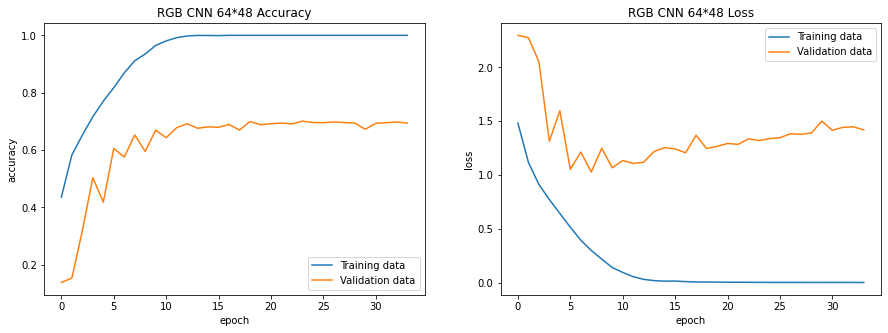

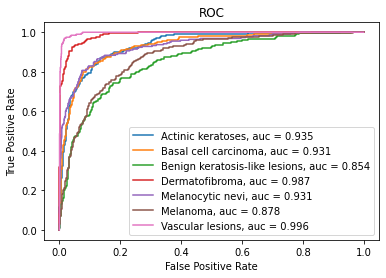

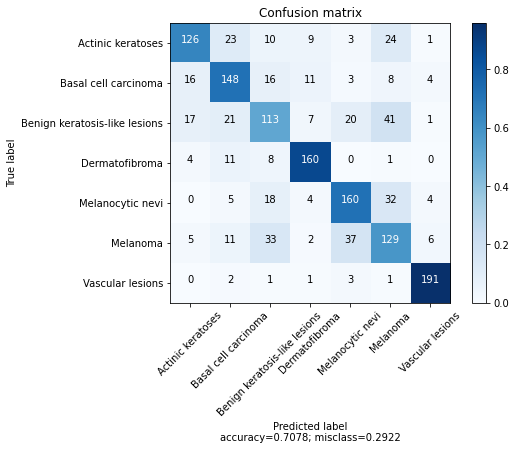

In [127]:
plot_history(h_rgb_64_48,'RGB CNN 64*48')
plot_roc(rgb_64_48_concatenated,[rgb_x_test_64_48,rgb_age_test_64_48,rgb_sex_test_64_48,rgb_localization_test_64_48],rgb_y_test_64_48)
cm_rgb_64_48=confusion_matrix(rgb_y_test_64_48, np.argmax(rgb_64_48_concatenated.predict([rgb_x_test_64_48,rgb_age_test_64_48,rgb_sex_test_64_48,rgb_localization_test_64_48]),axis=1))
plot_confusion_matrix(cm_rgb_64_48,sorted(cell_type_idx_dict.values()))


In [0]:
rgb_64_48_concatenated.save('rgb_64_48_conc.h5')

In [0]:
rgb_64_48_model.load_weights('rgb_64_48.h5')

In [137]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
gray_64_48_concatenated.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1)
    #checkpoint
]
h_gray_64_48 = gray_64_48_concatenated.fit([np.array(gray_x_train_64_48),np.array(gray_age_train_64_48),np.array(gray_sex_train_64_48),np.array(gray_localization_train_64_48)],
                    np.array(gray_y_train_64_48), epochs = 100, batch_size = 32, 
                    validation_data = ([np.array(gray_x_validation_64_48),np.array(gray_age_validation_64_48),np.array(gray_sex_validation_64_48),np.array(gray_localization_validation_64_48)],
                                       np.array(gray_y_validation_64_48)), callbacks = callbacks)

Epoch 1/100
136/136 [==============================] - 2s 15ms/step - loss: 1.7789 - accuracy: 0.3076 - val_loss: 2.8237 - val_accuracy: 0.1268
Epoch 2/100
136/136 [==============================] - 2s 14ms/step - loss: 1.5027 - accuracy: 0.4034 - val_loss: 3.1537 - val_accuracy: 0.1130
Epoch 3/100
136/136 [==============================] - 2s 14ms/step - loss: 1.3829 - accuracy: 0.4513 - val_loss: 3.0739 - val_accuracy: 0.1585
Epoch 4/100
136/136 [==============================] - 2s 14ms/step - loss: 1.2805 - accuracy: 0.4989 - val_loss: 2.1905 - val_accuracy: 0.2068
Epoch 5/100
136/136 [==============================] - 2s 14ms/step - loss: 1.1784 - accuracy: 0.5476 - val_loss: 1.6187 - val_accuracy: 0.3694
Epoch 6/100
136/136 [==============================] - 2s 14ms/step - loss: 1.0514 - accuracy: 0.5972 - val_loss: 1.5471 - val_accuracy: 0.3894
Epoch 7/100
136/136 [==============================] - 2s 14ms/step - loss: 0.9372 - accuracy: 0.6543 - val_loss: 1.6754 - val_accuracy:

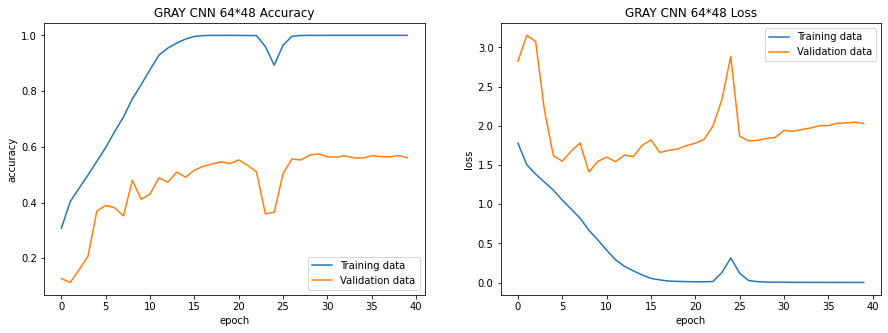

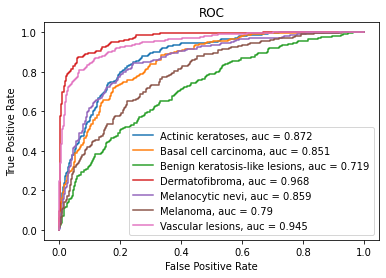

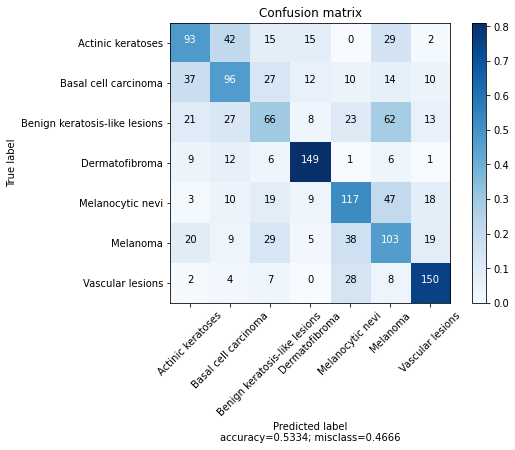

In [138]:
plot_history(h_gray_64_48,'GRAY CNN 64*48')
plot_roc(gray_64_48_concatenated,[gray_x_test_64_48,gray_age_test_64_48,gray_sex_test_64_48,gray_localization_test_64_48],gray_y_test_64_48)
cm_gray_64_48=confusion_matrix(gray_y_test_64_48, np.argmax(gray_64_48_concatenated.predict([gray_x_test_64_48,gray_age_test_64_48,gray_sex_test_64_48,gray_localization_test_64_48]),axis=1))
plot_confusion_matrix(cm_gray_64_48,sorted(cell_type_idx_dict.values()))

In [0]:
gray_64_48_concatenated.save('gray_64_48_conc.h5')

In [0]:
rgb_48_36_input=Input(shape=(36,48,3),name='Image')
rgb_48_36_age=Input(shape=1,name='Age')
rgb_48_36_sex=Input(shape=3,name='Sex')
rgb_48_36_localization=Input(shape=14,name='Localization')
rgb_48_36_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(rgb_48_36_input)
rgb_48_36_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(rgb_48_36_CNN)
rgb_48_36_CNN=BatchNormalization()(rgb_48_36_CNN)
rgb_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_48_36_CNN)
rgb_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_48_36_CNN)
rgb_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_48_36_CNN)
rgb_48_36_CNN=BatchNormalization()(rgb_48_36_CNN)
rgb_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_48_36_CNN)
rgb_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_48_36_CNN)
rgb_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(rgb_48_36_CNN)
rgb_48_36_CNN=BatchNormalization()(rgb_48_36_CNN)
rgb_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(rgb_48_36_CNN)
rgb_48_36_flatten=Flatten()(rgb_48_36_CNN)
rgb_48_36_conc=concatenate([rgb_48_36_flatten,rgb_48_36_age,rgb_48_36_sex,rgb_48_36_localization])
rgb_48_36_dense=Dense(128,activation='relu')(rgb_48_36_conc)
rgb_48_36_dense=Dense(64,activation='relu')(rgb_48_36_dense)
rgb_48_36_output=Dense(7,activation='softmax')(rgb_48_36_dense)
rgb_48_36_concatenated=Model(inputs=[rgb_48_36_input,rgb_48_36_age,rgb_48_36_sex,rgb_48_36_localization],outputs=rgb_48_36_output)

In [144]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
rgb_48_36_concatenated.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1)
    #checkpoint
]
h_rgb_48_36 = rgb_48_36_concatenated.fit([np.array(rgb_x_train_48_36),np.array(rgb_age_train_48_36),np.array(rgb_sex_train_48_36),np.array(rgb_localization_train_48_36)],
                    np.array(rgb_y_train_48_36), epochs = 100, batch_size = 32, 
                    validation_data = ([np.array(rgb_x_validation_48_36),np.array(rgb_age_validation_48_36),np.array(rgb_sex_validation_48_36),np.array(rgb_localization_validation_48_36)],
                                       np.array(rgb_y_validation_48_36)), callbacks = callbacks)

Epoch 1/100
136/136 [==============================] - 2s 12ms/step - loss: 1.5708 - accuracy: 0.3949 - val_loss: 2.1811 - val_accuracy: 0.1413
Epoch 2/100
136/136 [==============================] - 1s 11ms/step - loss: 1.1457 - accuracy: 0.5710 - val_loss: 2.4267 - val_accuracy: 0.1771
Epoch 3/100
136/136 [==============================] - 1s 10ms/step - loss: 0.9636 - accuracy: 0.6391 - val_loss: 2.3373 - val_accuracy: 0.2116
Epoch 4/100
136/136 [==============================] - 1s 11ms/step - loss: 0.8100 - accuracy: 0.7055 - val_loss: 1.6857 - val_accuracy: 0.3742
Epoch 5/100
136/136 [==============================] - 1s 11ms/step - loss: 0.7019 - accuracy: 0.7439 - val_loss: 1.0653 - val_accuracy: 0.6023
Epoch 6/100
136/136 [==============================] - 1s 11ms/step - loss: 0.5828 - accuracy: 0.7926 - val_loss: 1.0120 - val_accuracy: 0.6361
Epoch 7/100
136/136 [==============================] - 1s 11ms/step - loss: 0.4739 - accuracy: 0.8356 - val_loss: 1.1392 - val_accuracy:

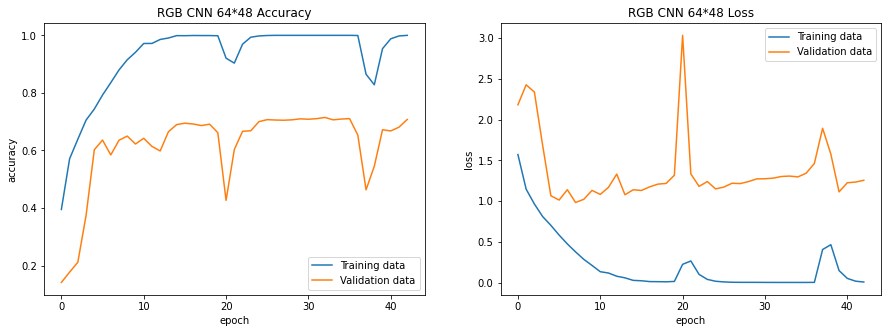

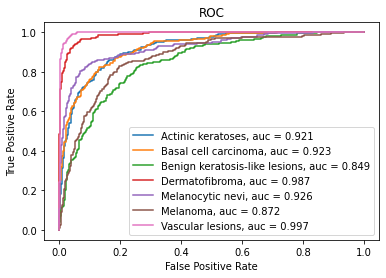

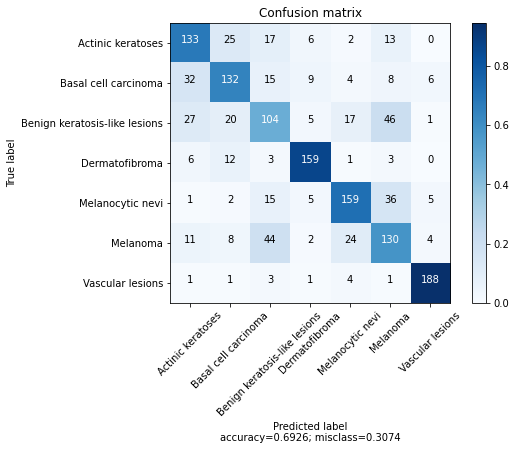

In [145]:
plot_history(h_rgb_48_36,'RGB CNN 64*48')
plot_roc(rgb_48_36_concatenated,[rgb_x_test_48_36,rgb_age_test_48_36,rgb_sex_test_48_36,rgb_localization_test_48_36],rgb_y_test_48_36)
cm_rgb_48_36=confusion_matrix(rgb_y_test_48_36, np.argmax(rgb_48_36_concatenated.predict([rgb_x_test_48_36,rgb_age_test_48_36,rgb_sex_test_48_36,rgb_localization_test_48_36]),axis=1))
plot_confusion_matrix(cm_rgb_48_36,sorted(cell_type_idx_dict.values()))

In [0]:
rgb_48_36_concatenated.save('rgb_48_36_conc.h5')

In [0]:
gray_48_36_input=Input(shape=(36,48,1),name='Image')
gray_48_36_age=Input(shape=1,name='Age')
gray_48_36_sex=Input(shape=3,name='Sex')
gray_48_36_localization=Input(shape=14,name='Localization')
gray_48_36_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(gray_48_36_input)
gray_48_36_CNN=Conv2D(64, (3,3), activation = "relu", padding = "same")(gray_48_36_CNN)
gray_48_36_CNN=BatchNormalization()(gray_48_36_CNN)
gray_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_48_36_CNN)
gray_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_48_36_CNN)
gray_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_48_36_CNN)
gray_48_36_CNN=BatchNormalization()(gray_48_36_CNN)
gray_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_48_36_CNN)
gray_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_48_36_CNN)
gray_48_36_CNN=Conv2D(128, (3,3), activation = "relu", padding = "same")(gray_48_36_CNN)
gray_48_36_CNN=BatchNormalization()(gray_48_36_CNN)
gray_48_36_CNN=MaxPooling2D(pool_size=(2,2),strides=(2,2))(gray_48_36_CNN)
gray_48_36_flatten=Flatten()(gray_48_36_CNN)
gray_48_36_conc=concatenate([gray_48_36_flatten,gray_48_36_age,gray_48_36_sex,gray_48_36_localization])
gray_48_36_dense=Dense(128,activation='relu')(gray_48_36_conc)
gray_48_36_dense=Dense(64,activation='relu')(gray_48_36_dense)
gray_48_36_output=Dense(7,activation='softmax')(gray_48_36_dense)
gray_48_36_concatenated=Model(inputs=[gray_48_36_input,gray_48_36_age,gray_48_36_sex,gray_48_36_localization],outputs=gray_48_36_output)

In [158]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
gray_48_36_concatenated.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1)
    #checkpoint
]
h_gray_48_36 = gray_48_36_concatenated.fit([np.array(gray_x_train_48_36),np.array(gray_age_train_48_36),np.array(gray_sex_train_48_36),np.array(gray_localization_train_48_36)],
                    np.array(gray_y_train_48_36), epochs = 100, batch_size = 32, 
                    validation_data = ([np.array(gray_x_validation_48_36),np.array(gray_age_validation_48_36),np.array(gray_sex_validation_48_36),np.array(gray_localization_validation_48_36)],
                                       np.array(gray_y_validation_48_36)), callbacks = callbacks)

Epoch 1/100
136/136 [==============================] - 2s 12ms/step - loss: 1.7731 - accuracy: 0.3094 - val_loss: 2.1253 - val_accuracy: 0.1351
Epoch 2/100
136/136 [==============================] - 1s 10ms/step - loss: 1.5102 - accuracy: 0.4067 - val_loss: 2.2425 - val_accuracy: 0.1351
Epoch 3/100
136/136 [==============================] - 1s 10ms/step - loss: 1.3680 - accuracy: 0.4729 - val_loss: 2.1966 - val_accuracy: 0.1716
Epoch 4/100
136/136 [==============================] - 1s 11ms/step - loss: 1.2568 - accuracy: 0.5131 - val_loss: 1.9330 - val_accuracy: 0.2130
Epoch 5/100
136/136 [==============================] - 1s 11ms/step - loss: 1.1612 - accuracy: 0.5586 - val_loss: 1.4892 - val_accuracy: 0.4114
Epoch 6/100
136/136 [==============================] - 1s 11ms/step - loss: 1.0428 - accuracy: 0.6182 - val_loss: 1.4982 - val_accuracy: 0.4266
Epoch 7/100
136/136 [==============================] - 1s 11ms/step - loss: 0.9250 - accuracy: 0.6634 - val_loss: 2.0417 - val_accuracy:

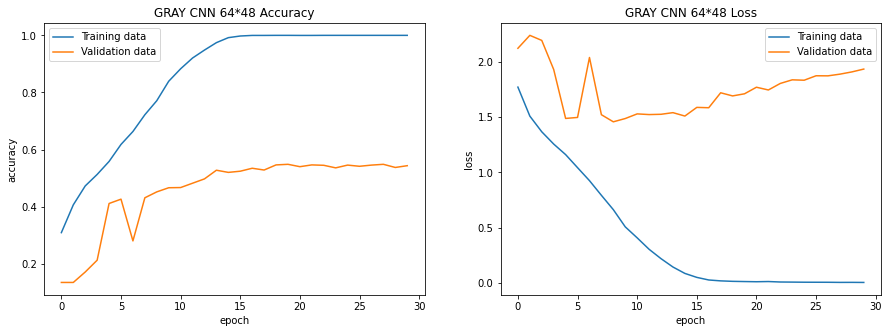

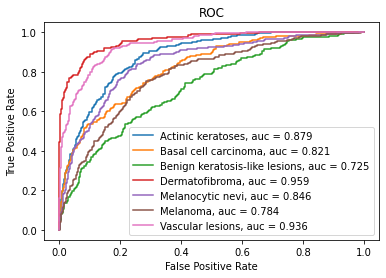

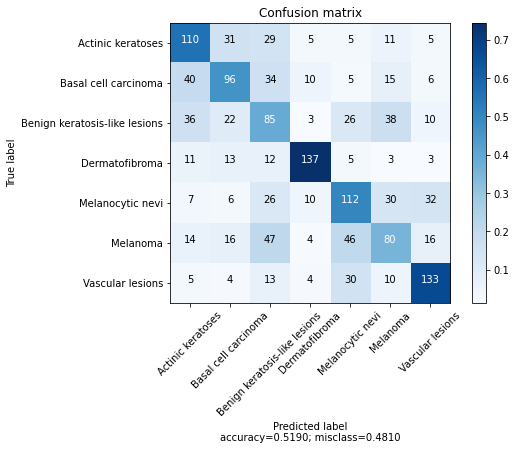

In [159]:
plot_history(h_gray_48_36,'GRAY CNN 64*48')
plot_roc(gray_48_36_concatenated,[gray_x_test_48_36,gray_age_test_48_36,gray_sex_test_48_36,gray_localization_test_48_36],gray_y_test_48_36)
cm_gray_48_36=confusion_matrix(gray_y_test_48_36, np.argmax(gray_48_36_concatenated.predict([gray_x_test_48_36,gray_age_test_48_36,gray_sex_test_48_36,gray_localization_test_48_36]),axis=1))
plot_confusion_matrix(cm_gray_48_36,sorted(cell_type_idx_dict.values()))

In [0]:
gray_48_36_concatenated.save('gray_48_36_conc.h5')

In [161]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
rgb_32_24_concatenated.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1)
    #checkpoint
]
h_rgb_32_24 = rgb_32_24_concatenated.fit([np.array(rgb_x_train_32_24),np.array(rgb_age_train_32_24),np.array(rgb_sex_train_32_24),np.array(rgb_localization_train_32_24)],
                    np.array(rgb_y_train_32_24), epochs = 100, batch_size = 32, 
                    validation_data = ([np.array(rgb_x_validation_32_24),np.array(rgb_age_validation_32_24),np.array(rgb_sex_validation_32_24),np.array(rgb_localization_validation_32_24)],
                                       np.array(rgb_y_validation_32_24)), callbacks = callbacks)

Epoch 1/100
136/136 [==============================] - 1s 10ms/step - loss: 1.6470 - accuracy: 0.3876 - val_loss: 2.8913 - val_accuracy: 0.1978
Epoch 2/100
136/136 [==============================] - 1s 8ms/step - loss: 1.1989 - accuracy: 0.5529 - val_loss: 2.7385 - val_accuracy: 0.1861
Epoch 3/100
136/136 [==============================] - 1s 7ms/step - loss: 1.0066 - accuracy: 0.6216 - val_loss: 2.1701 - val_accuracy: 0.2205
Epoch 4/100
136/136 [==============================] - 1s 8ms/step - loss: 0.8475 - accuracy: 0.6894 - val_loss: 1.5081 - val_accuracy: 0.4431
Epoch 5/100
136/136 [==============================] - 1s 8ms/step - loss: 0.7086 - accuracy: 0.7446 - val_loss: 1.1970 - val_accuracy: 0.5527
Epoch 6/100
136/136 [==============================] - 1s 8ms/step - loss: 0.5812 - accuracy: 0.7975 - val_loss: 1.1736 - val_accuracy: 0.5589
Epoch 7/100
136/136 [==============================] - 1s 8ms/step - loss: 0.4897 - accuracy: 0.8301 - val_loss: 1.0483 - val_accuracy: 0.625

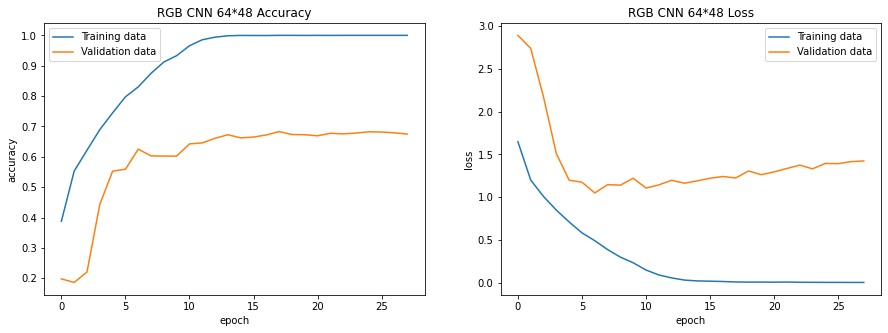

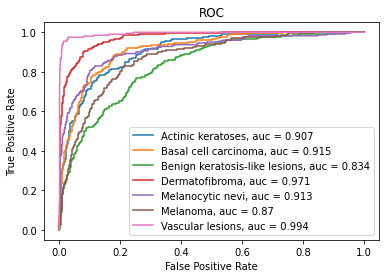

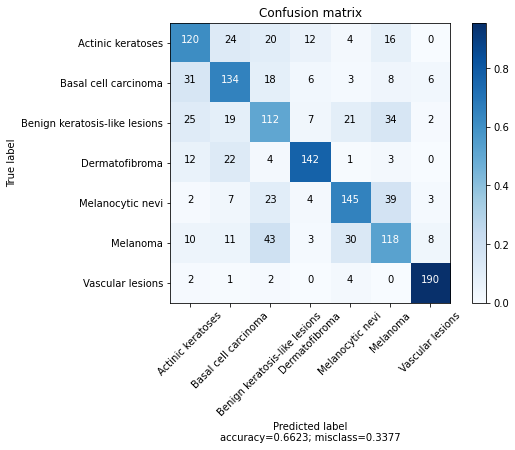

In [162]:
plot_history(h_rgb_32_24,'RGB CNN 64*48')
plot_roc(rgb_32_24_concatenated,[rgb_x_test_32_24,rgb_age_test_32_24,rgb_sex_test_32_24,rgb_localization_test_32_24],rgb_y_test_32_24)
cm_rgb_32_24=confusion_matrix(rgb_y_test_32_24, np.argmax(rgb_32_24_concatenated.predict([rgb_x_test_32_24,rgb_age_test_32_24,rgb_sex_test_32_24,rgb_localization_test_32_24]),axis=1))
plot_confusion_matrix(cm_rgb_32_24,sorted(cell_type_idx_dict.values()))

In [0]:
rgb_32_24_concatenated.save('rgb_32_24_conc.h5')

In [166]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = Adam(lr = 0.0001)
metrics = ["accuracy"]
gray_32_24_concatenated.compile(loss= loss, optimizer = optimizer, metrics = metrics)
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model/model-{epoch:02d}-{val_accuracy:.3f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1)
    #checkpoint
]
h_gray_32_24 = gray_32_24_concatenated.fit([np.array(gray_x_train_32_24),np.array(gray_age_train_32_24),np.array(gray_sex_train_32_24),np.array(gray_localization_train_32_24)],
                    np.array(gray_y_train_32_24), epochs = 100, batch_size = 32, 
                    validation_data = ([np.array(gray_x_validation_32_24),np.array(gray_age_validation_32_24),np.array(gray_sex_validation_32_24),np.array(gray_localization_validation_32_24)],
                                       np.array(gray_y_validation_32_24)), callbacks = callbacks)

Epoch 1/100
136/136 [==============================] - 1s 9ms/step - loss: 1.7981 - accuracy: 0.2961 - val_loss: 2.9723 - val_accuracy: 0.1496
Epoch 2/100
136/136 [==============================] - 1s 7ms/step - loss: 1.5239 - accuracy: 0.4147 - val_loss: 3.3733 - val_accuracy: 0.1496
Epoch 3/100
136/136 [==============================] - 1s 7ms/step - loss: 1.3987 - accuracy: 0.4628 - val_loss: 3.5044 - val_accuracy: 0.1509
Epoch 4/100
136/136 [==============================] - 1s 7ms/step - loss: 1.3138 - accuracy: 0.4908 - val_loss: 2.5824 - val_accuracy: 0.1626
Epoch 5/100
136/136 [==============================] - 1s 7ms/step - loss: 1.2062 - accuracy: 0.5457 - val_loss: 1.6285 - val_accuracy: 0.3673
Epoch 6/100
136/136 [==============================] - 1s 8ms/step - loss: 1.1133 - accuracy: 0.5756 - val_loss: 1.5187 - val_accuracy: 0.3942
Epoch 7/100
136/136 [==============================] - 1s 7ms/step - loss: 1.0031 - accuracy: 0.6303 - val_loss: 1.4403 - val_accuracy: 0.4356

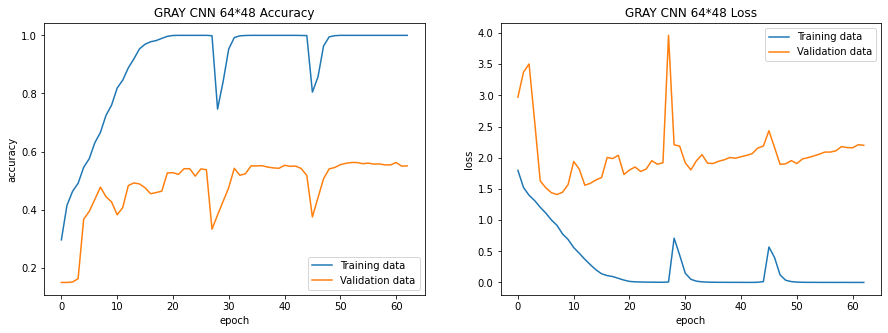

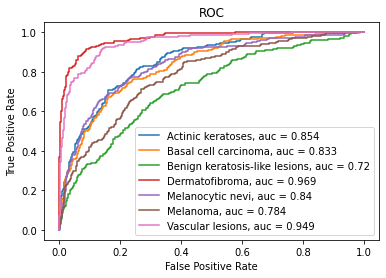

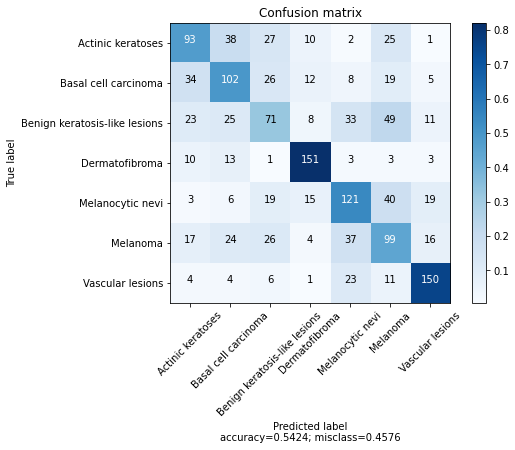

In [167]:
plot_history(h_gray_32_24,'GRAY CNN 64*48')
plot_roc(gray_32_24_concatenated,[gray_x_test_32_24,gray_age_test_32_24,gray_sex_test_32_24,gray_localization_test_32_24],gray_y_test_32_24)
cm_gray_32_24=confusion_matrix(gray_y_test_32_24, np.argmax(gray_32_24_concatenated.predict([gray_x_test_32_24,gray_age_test_32_24,gray_sex_test_32_24,gray_localization_test_32_24]),axis=1))
plot_confusion_matrix(cm_gray_32_24,sorted(cell_type_idx_dict.values()))

In [0]:
gray_32_24_concatenated.save('gray_32_24_conc.h5')

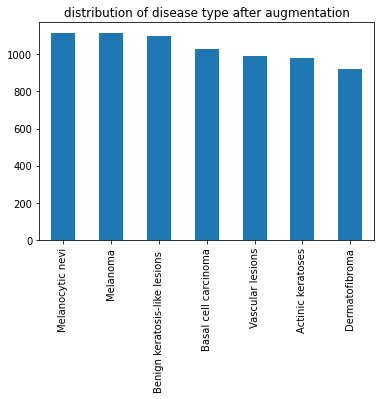

In [20]:
fig, ax1 = plt.subplots(1, 1)
meta_df_32_24_aug['cell_type'].value_counts().plot(kind='bar', ax=ax1)
plt.title('distribution of disease type after augmentation')
plt.savefig('aaa.png')

Text(0.5, 1.0, 'distribution of disease type')

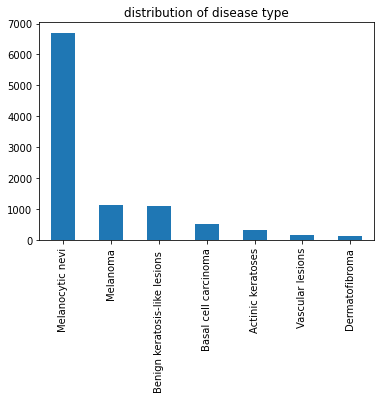

In [22]:
fig, ax1 = plt.subplots(1, 1)
meta_df_32_24['cell_type'].value_counts().plot(kind='bar', ax=ax1)
plt.title('distribution of disease type')

In [23]:
meta_df_32_24['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64